# Exploring Sleep Data

In [1]:
import pandas as pd
import numpy as np
from cmath import rect, phase
from math import radians, degrees, isnan
import matplotlib.pyplot as plt
import seaborn as sns   

In [2]:
# init sleep_df
filename = 'data/AutoSleep-20201220-to-20231002.csv'
sleep_df = pd.read_csv(filename, parse_dates=['bedtime', 'waketime'])
sleep_index = pd.to_datetime(sleep_df['ISO8601'], utc=True).dt.strftime('%Y-%m-%d').to_numpy()
sleep_df.index = sleep_index
print(sleep_df.info(verbose=False))
# print(sleep_df.columns)
# sleep_df.tail(3)

<class 'pandas.core.frame.DataFrame'>
Index: 916 entries, 2021-01-01 to 2023-10-01
Columns: 35 entries, ISO8601 to notes
dtypes: datetime64[ns](2), float64(20), int64(1), object(12)
memory usage: 257.6+ KB
None


In [3]:
# init and filter: rem_df -> filt_rem_df
filename = 'data/AutoSleep-20230613-to-20231002.csv'
rem_df = pd.read_csv(filename, parse_dates=['bedtime', 'waketime'])
rem_index = pd.to_datetime(rem_df['ISO8601'], utc=True).dt.strftime('%Y-%m-%d').to_numpy()
rem_df.index = rem_index
filt_rem_df = rem_df.loc[rem_df['REM'].notnull()]
print(filt_rem_df.info(verbose=False))
# print(filt_rem_df.columns)
# filt_rem_df.tail(3)

<class 'pandas.core.frame.DataFrame'>
Index: 99 entries, 2023-06-15 to 2023-10-01
Columns: 35 entries, ISO8601 to notes
dtypes: datetime64[ns](2), float64(18), int64(3), object(12)
memory usage: 27.8+ KB
None


In [4]:
# merged sleep_df and filt_rem_df into merged_df
merged_df = sleep_df.copy()

on = filt_rem_df.columns.intersection(sleep_df.columns).to_list()
others = filt_rem_df.columns.difference(sleep_df.columns).to_list()
for o in others:
    merged_df[o] = ''

merged_df.loc[sleep_df.index.isin(filt_rem_df.index), on] = filt_rem_df
merged_df.loc[sleep_df.index.isin(filt_rem_df.index), others] = filt_rem_df
print(merged_df.info(verbose=False))
# print(merged_df.columns)
# merged_df.tail(3)

<class 'pandas.core.frame.DataFrame'>
Index: 916 entries, 2021-01-01 to 2023-10-01
Columns: 37 entries, ISO8601 to REMAvg7
dtypes: datetime64[ns](2), float64(20), int64(1), object(14)
memory usage: 271.9+ KB
None


In [5]:
# deleted 7-day average columns
clean_cols = ['fromDate', 'toDate', 'bedtime', 'waketime', 'inBed', 'awake', 
              'fellAsleepIn', 'sessions', 'asleep', 'efficiency', 'quality', 
              'deep', 'sleepBPM', 'dayBPM', 'wakingBPM', 'hrv', 'sleepHRV',
              'SpO2Avg', 'SpO2Min', 'SpO2Max', 'respAvg', 'respMin', 'respMax', 
              'REM']

clean_df = merged_df.loc[:, clean_cols]
clean_df.columns
# print(len(clean_df))
# clean_df.tail(3)

Index(['fromDate', 'toDate', 'bedtime', 'waketime', 'inBed', 'awake',
       'fellAsleepIn', 'sessions', 'asleep', 'efficiency', 'quality', 'deep',
       'sleepBPM', 'dayBPM', 'wakingBPM', 'hrv', 'sleepHRV', 'SpO2Avg',
       'SpO2Min', 'SpO2Max', 'respAvg', 'respMin', 'respMax', 'REM'],
      dtype='object')

In [6]:
def assign_timezones(old_df, columns, local_tz, current_tz, start_date=None, end_date=None):
    
    df = old_df.copy()
    
    def localize_and_convert(ser):
        new_ser = ser.dt.tz_localize(current_tz, nonexistent='shift_backward')
        new_ser = new_ser.dt.tz_convert(local_tz)
        dates = new_ser.dt.strftime('%Y-%m-%d')
        times = pd.to_datetime(new_ser, utc=True).dt.strftime('%Y-%m-%d %H:%M:%S')
        return dates, times
    
    def filter(column, date):
        if end_date and not start_date:
            ser = df.loc[df.index < end_date, column]
            dates, times = localize_and_convert(ser)
            df.loc[df.index < end_date, column] = times
            df.loc[df.index < end_date, date] = dates
            df.loc[df.index < end_date, 'tz'] = local_tz
                    
        elif start_date and not end_date:
            ser = df.loc[df.index >= start_date, column]
            dates, times = localize_and_convert(ser)
            df.loc[df.index >= start_date, column] = times
            df.loc[df.index >= start_date, date] = dates
            df.loc[df.index >= start_date, 'tz'] = local_tz

        else:
            ser = df.loc[(df.index >= start_date) & (df.index < end_date), column]
            dates, times = localize_and_convert(ser)
            df.loc[(df.index >= start_date) & (df.index < end_date), column] = times
            df.loc[(df.index >= start_date) & (df.index < end_date), date] = dates
            df.loc[(df.index >= start_date) & (df.index < end_date), 'tz'] = local_tz
            
    for col in columns:
        if col == 'bedtime':
            filter(col, 'fromDate')
        elif col == 'waketime':
            filter(col, 'toDate')
        else:
            print('error')
        
    return df

In [7]:
# formatted dates to be accurate to time zones and created categorical tz column
current_tz = 'Europe/Berlin'
tz_df = clean_df.copy()
tz_df['tz'] = ''
tz_df = assign_timezones(tz_df, ['bedtime', 'waketime'], 'US/Mountain', current_tz, end_date='2021-05-10')
tz_df = assign_timezones(tz_df, ['bedtime', 'waketime'], 'US/Eastern', current_tz, start_date='2021-05-10', end_date='2022-09-22')
tz_df = assign_timezones(tz_df, ['bedtime', 'waketime'], 'US/Central', current_tz, start_date='2022-08-23', end_date='2022-09-29')
tz_df = assign_timezones(tz_df, ['bedtime', 'waketime'], 'Europe/Berlin', current_tz, start_date='2022-09-29')
tz_df['tz'].unique()
# display(tz_df.head(3))
# tz_df.tail(3)

array(['US/Mountain', 'US/Eastern', 'US/Central', 'Europe/Berlin'],
      dtype=object)

In [8]:
# new column for categorical dates: Early 2021, Late 2021, Early 2022, Late 2022, Early 2023, Late 2023
def date_cats(dates):
    cats = []
    for date in dates:
        year = date[:4]
        if int(date[5:7]) < 7:
            season = 'Early'
        else:
            season = 'Late'
        cats.append(f'{season} {year}') 
        
    return cats

In [9]:
# created new df, comparing apparent sleep (waketime - bedtime) to actual sleep (asleep): mult_sesh_df
mult_sesh_df = tz_df.loc[:, ['toDate', 'tz']]
mult_sesh_df['date_cats'] = date_cats(mult_sesh_df['toDate'])

mult_sesh_df.loc[:, ['bedtime', 'waketime']] = tz_df.loc[:, ['bedtime', 'waketime']]
timed_sleep = (mult_sesh_df['waketime'] - mult_sesh_df['bedtime'])
mult_sesh_df['timed_sleep_hrs'] = np.round((timed_sleep.dt.total_seconds() / 3600), 2)

mult_sesh_df.loc[:, 'asleep'] = tz_df.loc[:, 'asleep']
slp_hrs = [int(i[:2]) for i in mult_sesh_df['asleep'].values]
slp_mins = [int(i[3:5]) for i in mult_sesh_df['asleep'].values]
mult_sesh_df['asleep_hrs'] = [np.round((slp_hrs[i] + slp_mins[i]/60), 2) for i in range(len(slp_mins))]

mult_sesh_df['time_diff'] = mult_sesh_df['asleep_hrs'] - mult_sesh_df['timed_sleep_hrs']
print('time_diff = minutes "asleep" - (waketime - bedtime)')

time_diff = minutes "asleep" - (waketime - bedtime)


In [28]:
# moved new columns and values to main df: simp_times_df
tz_df['date_cats'] = mult_sesh_df['date_cats']
tz_df['asleep_hrs'] = mult_sesh_df['asleep_hrs']

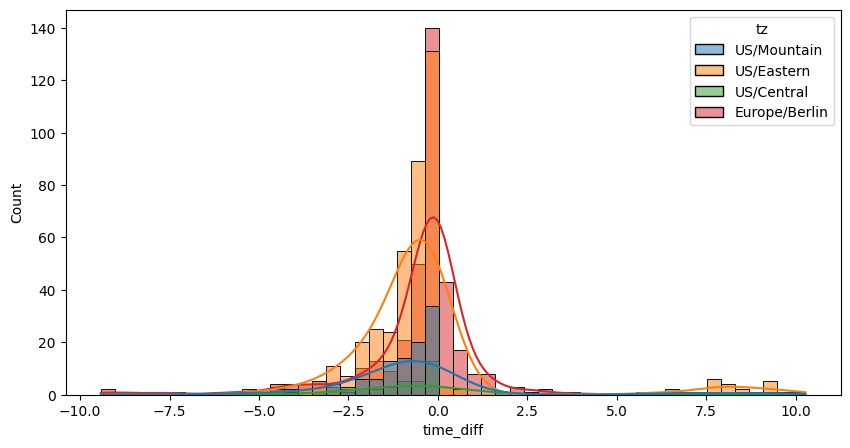

In [11]:
tdax = sns.histplot(data=mult_sesh_df, x='time_diff', bins=50, kde=True, hue='tz')
tdax.figure.set_size_inches(10, 5)

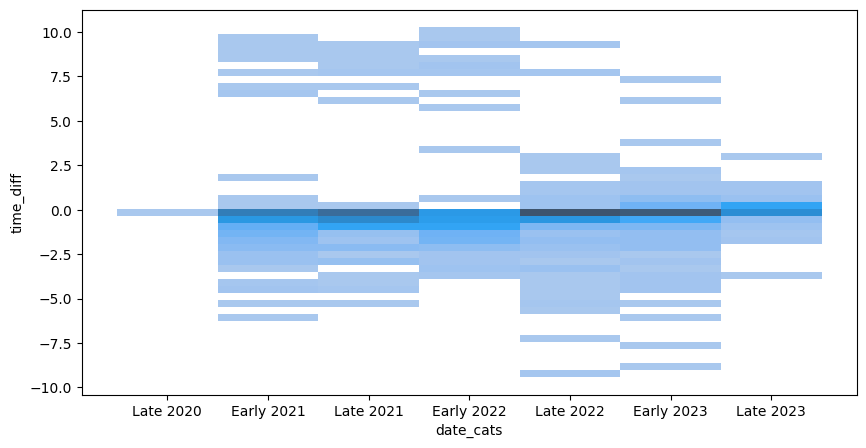

In [12]:
tdax1 = sns.histplot(data=mult_sesh_df, x='date_cats', y='time_diff', kde=True, bins=50)
tdax1.figure.set_size_inches(10, 5)

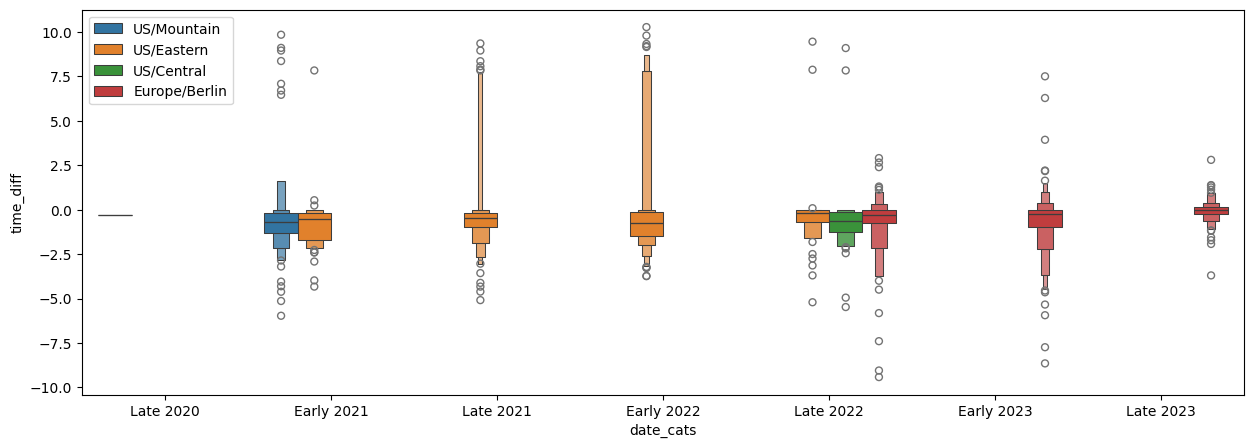

In [13]:
axo = sns.boxenplot(x='date_cats', y='time_diff', hue='tz', data=mult_sesh_df)
axo.figure.set_size_inches(15, 5)
axo.legend(loc='upper left')

In [14]:
mult_sesh_df['time_diff'].describe()

count    916.000000
mean      -0.442358
std        2.142761
min       -9.420000
25%       -1.100000
50%       -0.395000
75%        0.000000
max       10.270000
Name: time_diff, dtype: float64

In [15]:
# excluded_dates (outliers) = 2 std devs from mean
upper_lim = mult_sesh_df['time_diff'].mean() + 2*mult_sesh_df['time_diff'].std()
lower_lim = mult_sesh_df['time_diff'].mean() - 2*mult_sesh_df['time_diff'].std()
excluded_dates = mult_sesh_df.loc[(mult_sesh_df['time_diff'] > upper_lim) | \
    (mult_sesh_df['time_diff'] < lower_lim)]
print('loss: ', f'{np.round((len(excluded_dates)/len(mult_sesh_df)*100), 2)}%')

loss:  5.46%


In [16]:
# deleted outliers from dataset: filtered_df
filtered_df = tz_df.loc[tz_df.index.isin(excluded_dates.index) == False]
filtered_df.info(verbose=False)
# print(len(filtered_df))
# filtered_df.tail(3)

<class 'pandas.core.frame.DataFrame'>
Index: 866 entries, 2021-01-01 to 2023-10-01
Columns: 27 entries, fromDate to asleep_hrs
dtypes: datetime64[ns](2), float64(13), int64(1), object(11)
memory usage: 189.4+ KB


In [17]:
# fuctions to get mean times on 24hr clock
def mean_angle(deg):
    return degrees(phase(sum(rect(1, radians(d)) for d in deg)/len(deg)))

def mean_time(times):
    if type(times.iloc[0]) != str:
        times = times.dt.strftime('%H:%M:%S')
    t_list = (time.split(':') for time in times if type(time) == str and time != '')
    seconds = ((float(s) + int(m) * 60 + int(h) * 3600) for h, m, s in t_list)
    day = 24 * 60 * 60
    to_angles = [s * 360. / day for s in seconds]
    mean_as_angle = mean_angle(to_angles)
    mean_seconds = mean_as_angle * day / 360.
    if mean_seconds < 0:
        mean_seconds += day
    h, m = divmod(mean_seconds, 3600)
    m, s = divmod(m, 60)
    return '%02i:%02i:%02i' % (h, m, s)

In [18]:
print('mean bedtime', mean_time(filtered_df['bedtime']))
print('mean waketime', mean_time(filtered_df['waketime']))
print('mean asleep', mean_time(filtered_df['asleep']))
print('mean quality', mean_time(filtered_df['quality']))
print('mean REM', mean_time(filtered_df['REM']))
print('mean deep', mean_time(filtered_df['deep']))

mean bedtime 03:57:30
mean waketime 12:35:05
mean asleep 07:43:51
mean quality 04:37:04
mean REM 01:48:57
mean deep 02:06:30


### Visualizations

In [32]:
# viz_df for plotting
viz_df = filtered_df.copy()
viz_df.columns

Index(['fromDate', 'toDate', 'bedtime', 'waketime', 'inBed', 'awake',
       'fellAsleepIn', 'sessions', 'asleep', 'efficiency', 'quality', 'deep',
       'sleepBPM', 'dayBPM', 'wakingBPM', 'hrv', 'sleepHRV', 'SpO2Avg',
       'SpO2Min', 'SpO2Max', 'respAvg', 'respMin', 'respMax', 'REM', 'tz',
       'date_cats', 'asleep_hrs'],
      dtype='object')

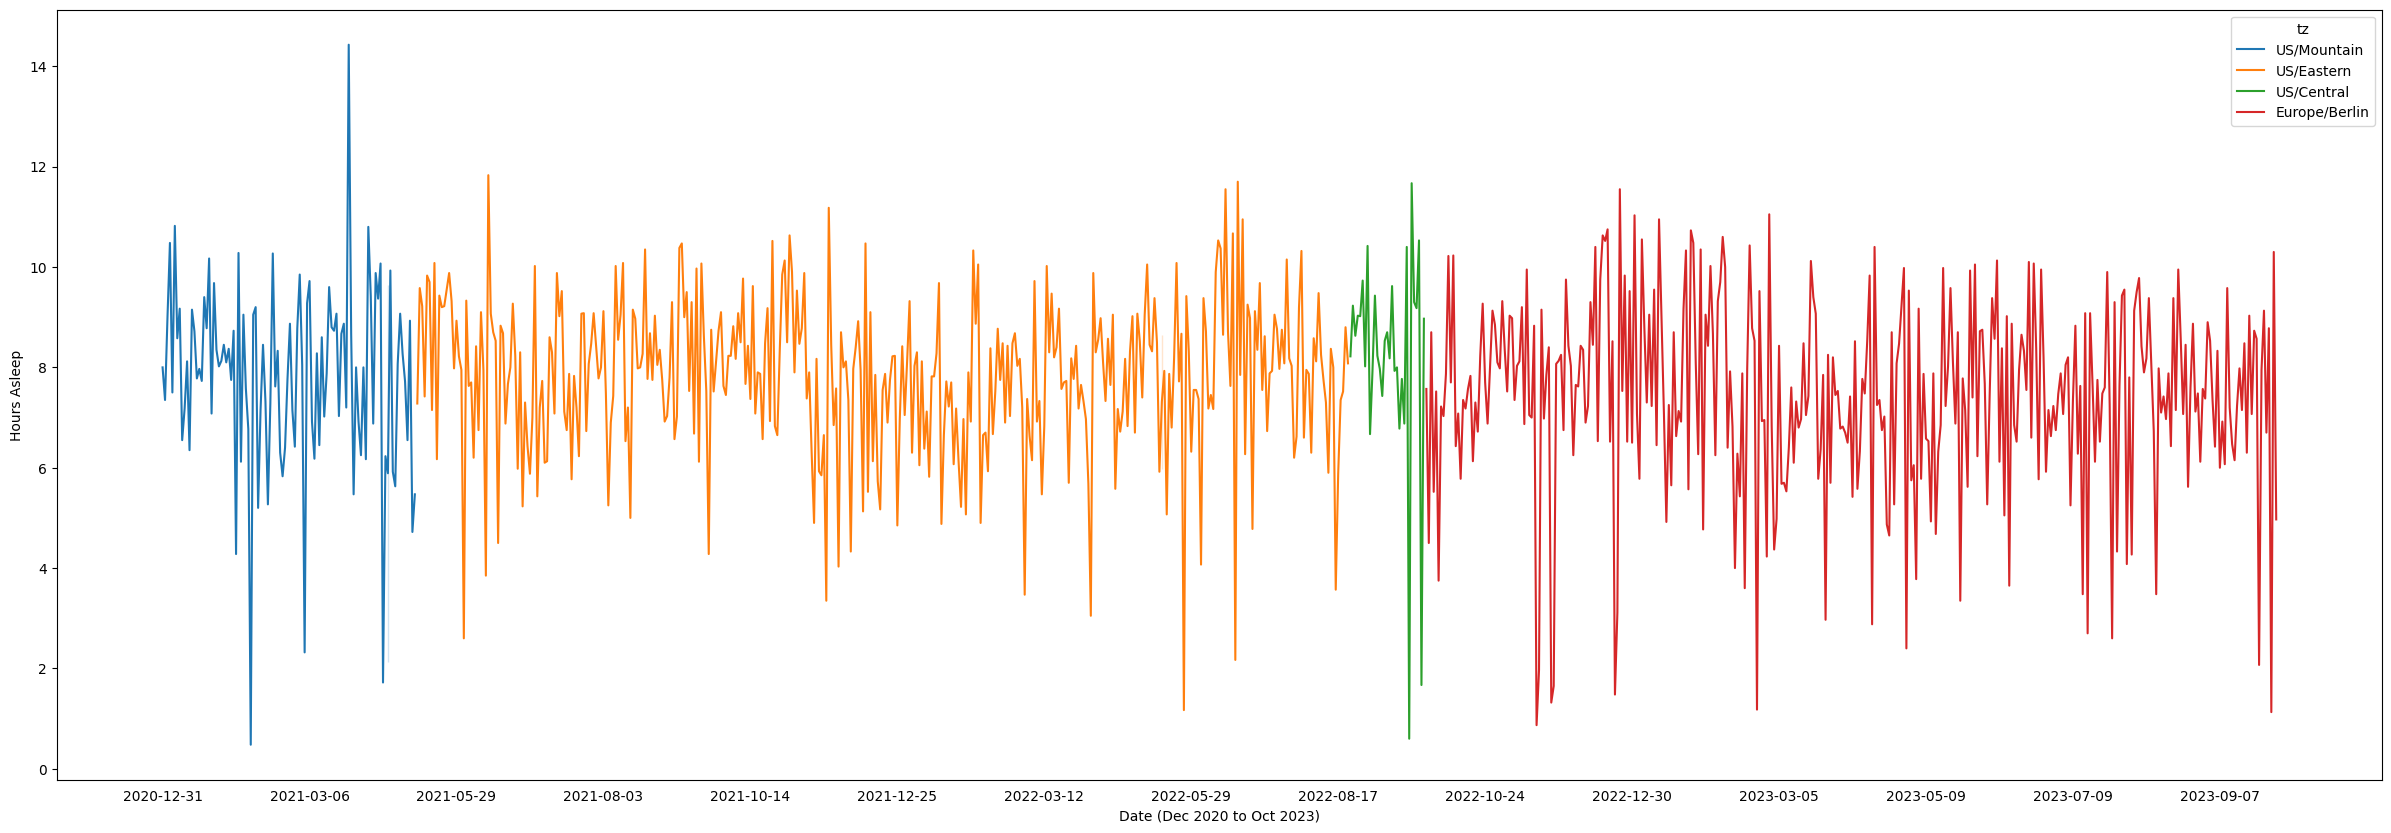

In [34]:
ax = sns.lineplot(data=viz_df, x='toDate', y='asleep_hrs', hue='tz')
ax.figure.set_size_inches(30, 10)
ax.set_ylabel('Hours Asleep')
ax.set_xlabel('Date (Dec 2020 to Oct 2023)')

x_ticks = ax.get_xticks()
x_labels = ax.get_xticklabels()
new_labels = []
new_ticks = []
for idx, lbl in enumerate(x_labels):
    if idx % 60 == 0:
        new_labels.append(lbl)
        new_ticks.append(x_ticks[idx])
ax.tick_params(axis='x', bottom=False, top=False)
ax.set_xticks(new_ticks)
ax.set_xticklabels(new_labels)
plt.show(ax)

In [36]:
print('mean: ', np.mean(viz_df['asleep_hrs'].values))
print('standard deviation: ', np.std(viz_df['asleep_hrs'].values))
print('var: ', np.var(viz_df['asleep_hrs'].values))

mean:  7.672771362586604
standard deviation:  1.8035253995698328
var:  3.252703866893525


In [64]:
# early bedtime = after 9pm (21:00:00) and before midnight (00:00:00)
# normal bedtime = after midnight (00:00:00) and before 3am (03:00:00)
# late bedtime = after 3am (03:00:00) and before 6am (06:00:00)
# abnormal bedtime = after 6am (06:00:00) and before 9pm (21:00:00)

# change scale to noon starting

def bedtime_conv_and_cat(bed_times):
    
    new_times = []
    cats = []
    offset_times = []
    
    bed_times = bed_times.dt.strftime('%H:%M:%S')   

    for bt in bed_times:
        h, m, s = bt.split(':')
        h = int(h)
        bthr = h + int(m)/60 + int(s)/3600
        new_times.append(bthr)
        
        if h >= 21:
            cats.append('early')
        elif h >= 0 and h < 3:
            cats.append('normal')
        elif h >= 3 and h < 6:
            cats.append('late')
        elif h >= 6 and h < 21:
            cats.append('abnormal')
            
        if h >= 12:
            offset_times.append((h-12) + int(m)/60 + int(s)/3600)
        else:
            offset_times.append((h+12) + int(m)/60 + int(s)/3600)
            
    return new_times, cats, offset_times

In [69]:
# early waketime == from 5am (05:00:00) to 8am (08:00:00)
# normal waketime == from 8am (08:00:00) to 11am (11:00:00)
# late waketime == from 11am (11:00:00) to 2pm (14:00:00)
# abnormal waketime == from 2pm (14:00:00) to 5am (05:00:00)
def waketime_convert(wake_times):
    
    new_times = []
    cats = []

    wake_times = wake_times.dt.strftime('%H:%M:%S')   

    for wt in wake_times:
        if type(wt) != str:
            print('type error: ', wt, type(wt))
            break
        
        h, m, s = wt.split(':')
        h = int(h)
        wthr = h + int(m)/60 + int(s)/3600
        new_times.append(wthr)
        
        if h >= 5 and h < 8:
            cats.append('early')
        elif h >= 8 and h < 11:
            cats.append('normal')
        elif h >= 11 and h < 14:
            cats.append('late')
        elif h >= 14 or h < 5:
            cats.append('abnormal')   
        else:
            print('error:', h)     
            break 
            
    return new_times, cats

In [73]:
# set categories of sleep time:
# less than 5 hours == 'terrible'
# 5-7 hour == 'poor'
# 7-9 hours == 'good'
# 9+ hours == 'too much
def asleep_cats(sleep_hrs):
        
    cats = []
    
    for sh in sleep_hrs:
        try:
            int(sh)
            if sh <= 5:
                cats.append('terrible')
            elif sh > 5 and sh <= 7: 
                cats.append('poor')
            elif sh > 7 and sh <= 9:
                cats.append('good')
            elif sh > 9:
                cats.append('too much')
            
        except:
            print('error: ', sh, type(sh))
            break
        
    return cats

In [76]:
# created categorical columns for bedtime, waketime, and asleep_hrs; offset bedtime
btwt_df = viz_df.loc[:, ['toDate', 'bedtime', 'waketime', 'asleep_hrs', 'quality', 'deep', 'REM', 'tz']]
btwt_df['bedtime'], btwt_df['bt_cat'], btwt_df['bedtime_offset'] = bedtime_conv_and_cat(btwt_df['bedtime'])
btwt_df['waketime'], btwt_df['wt_cat'] = waketime_convert(btwt_df['waketime'])
btwt_df['asleep_cat'] = asleep_cats(btwt_df['asleep_hrs'])
btwt_df.columns

Index(['toDate', 'bedtime', 'waketime', 'asleep_hrs', 'quality', 'deep', 'REM',
       'tz', 'bt_cat', 'bedtime_offset', 'wt_cat', 'asleep_cat'],
      dtype='object')

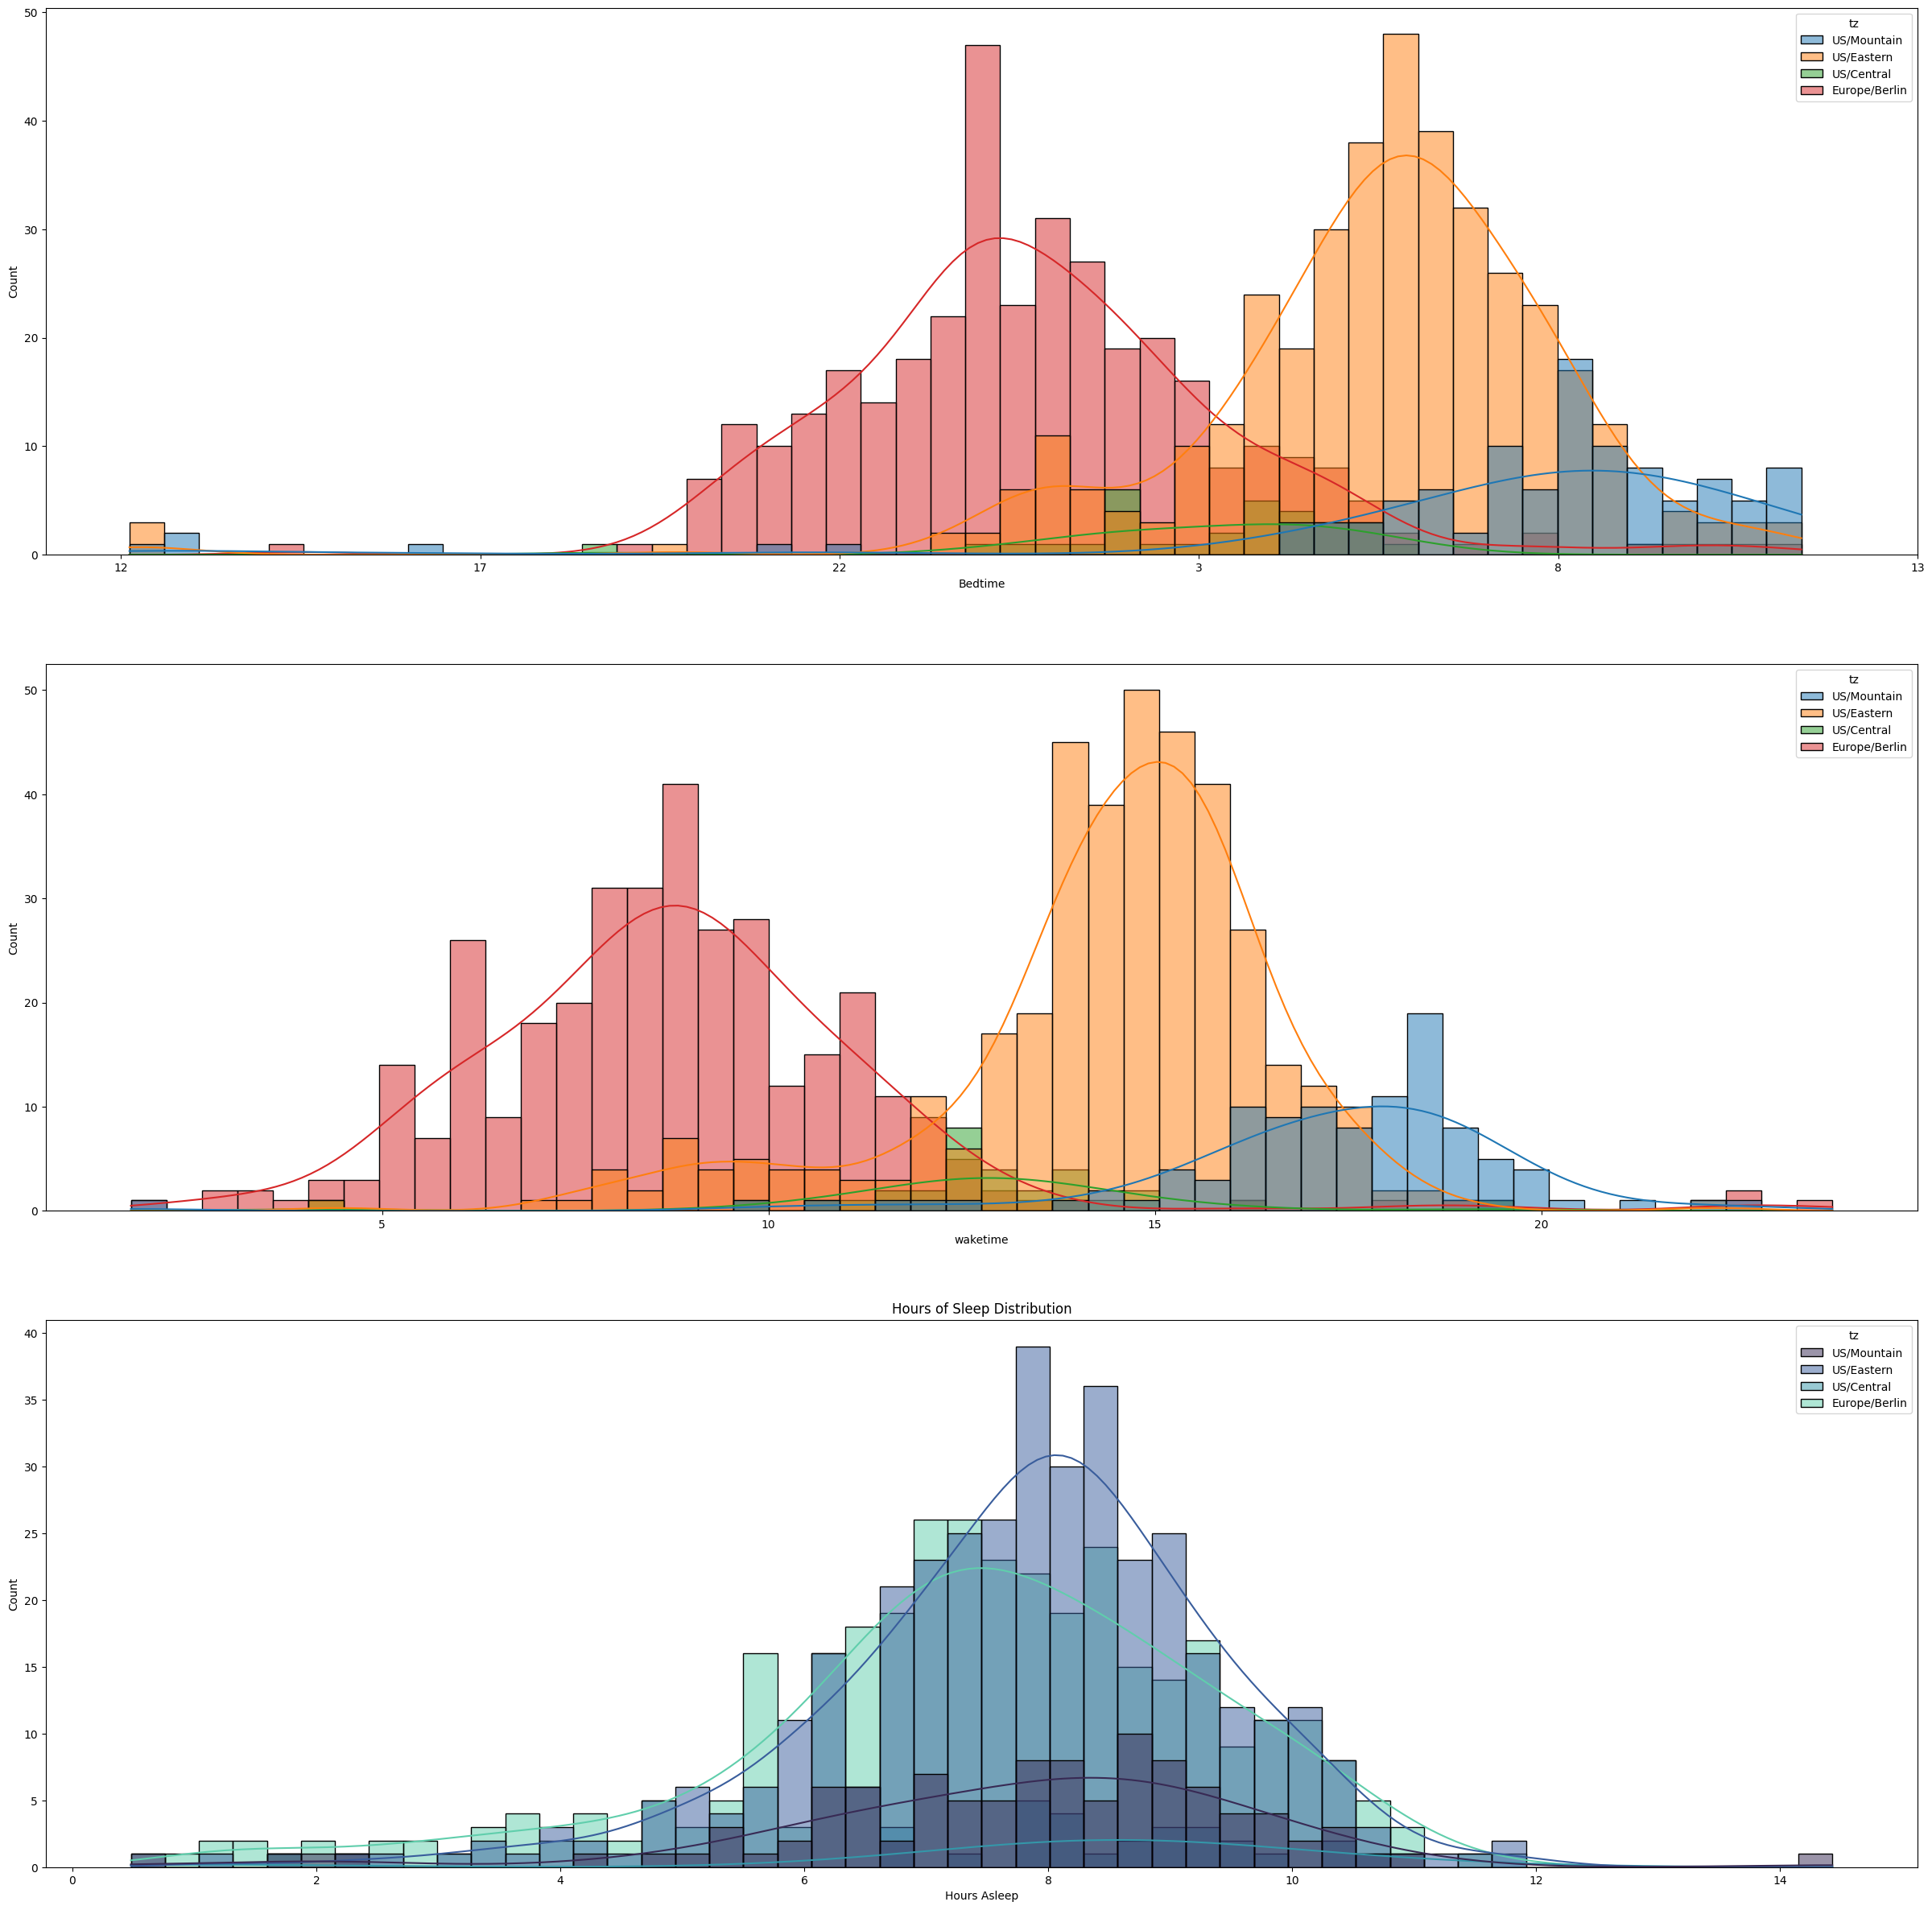

In [78]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30, 30))

ax1 = sns.histplot(data=btwt_df, x='bedtime_offset', kde=True, hue='tz', bins=48, ax=ax1)
bticks = ax1.get_xticks()
btimes = ax1.get_xticklabels()

new_bticks = []
new_btimes = []
for idx, bt in enumerate(btimes):
    try:
        hr = int(bt.get_text())
        new_bticks.append(bticks[idx])
        if hr < 12:
            new_btimes.append(hr+12)
        else:
            new_btimes.append(hr-12)
    except: 
        continue
     
ax1.set_xticks(new_bticks)
ax1.set_xticklabels(new_btimes)
ax1.set_xlabel('Bedtime')

ax2 = sns.histplot(data=btwt_df, x='waketime', kde=True, hue='tz', bins=48, ax=ax2)

ax3 = sns.histplot(data=btwt_df, x='asleep_hrs', hue='tz', kde=True, bins=50, ax=ax3, palette='mako')
ax3.set_xlabel('Hours Asleep')
ax3.set_title('Hours of Sleep Distribution')

plt.show(fig)

## start here next time: time zones fucked up?

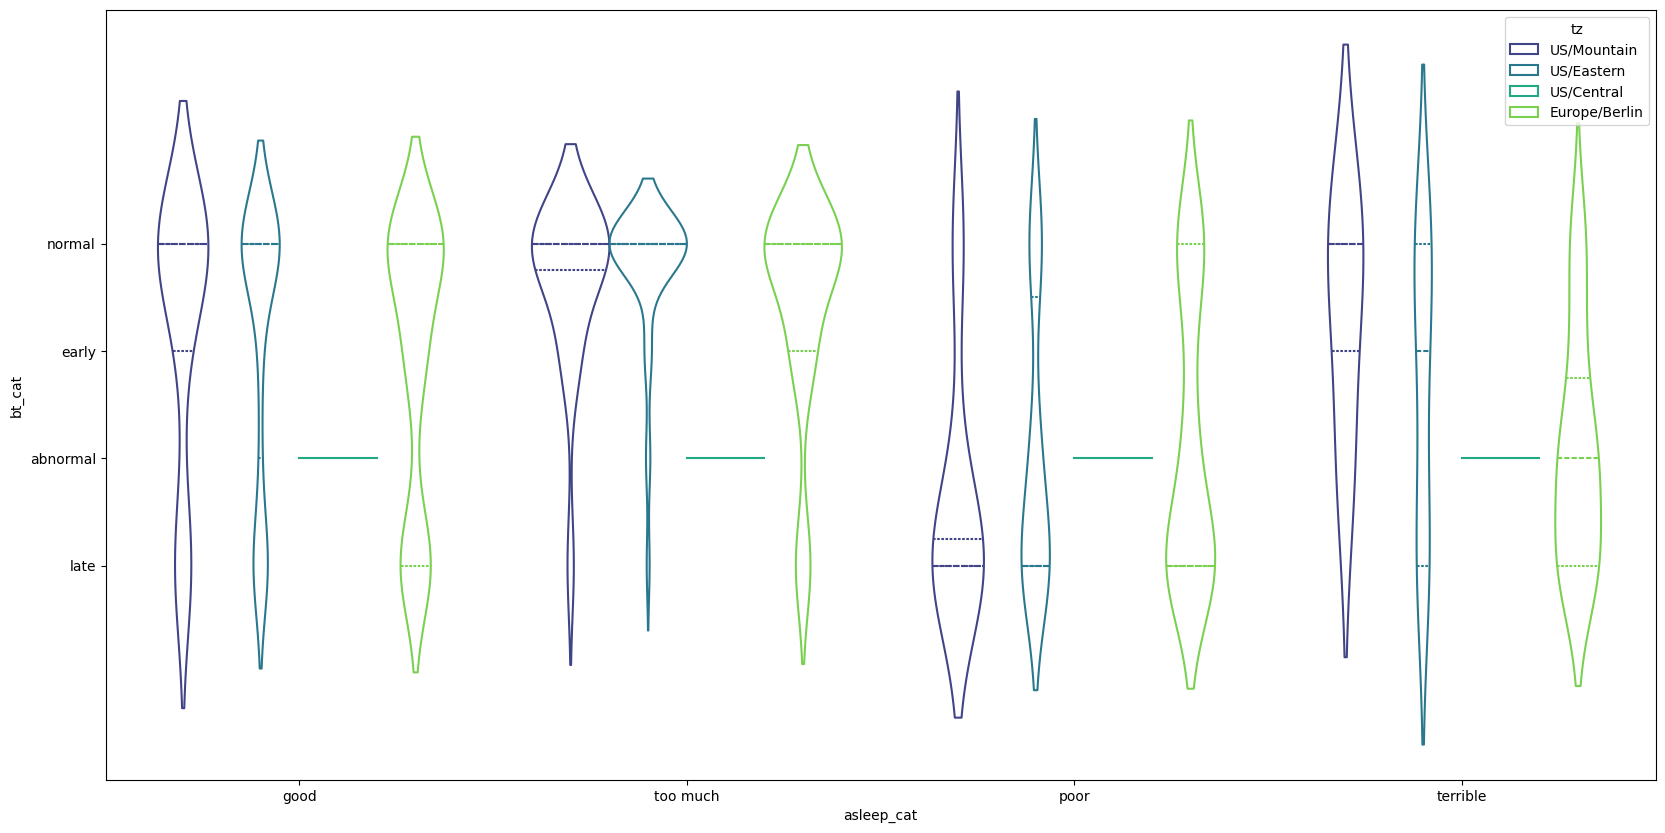

In [ ]:
ax4 = sns.violinplot(data=btwt_df, x="asleep_cat", y="bt_cat", hue="tz", inner="quart", fill=False, palette='viridis')
ax4.figure.set_size_inches(20, 10)
plt.show(ax4)

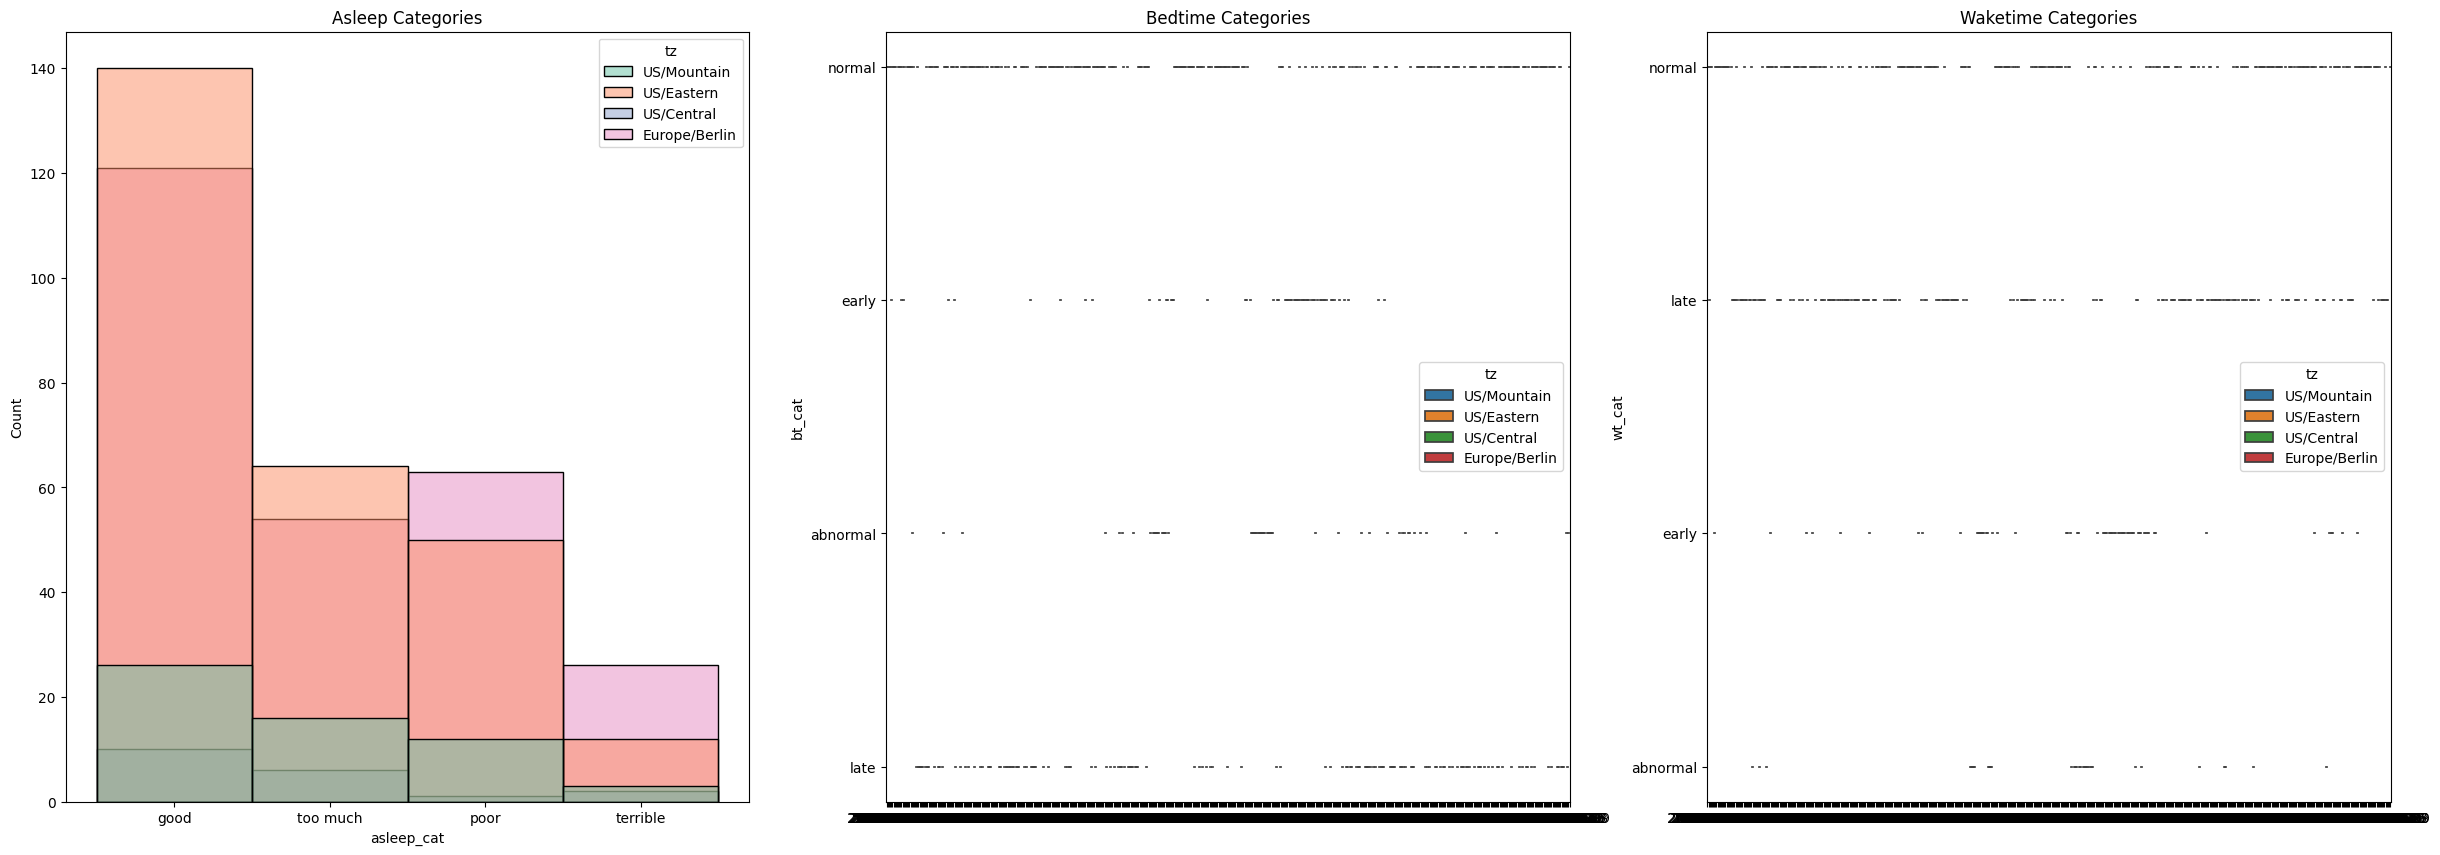

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
sns.histplot(data=btwt_df, x='asleep_cat', hue='tz', ax=axes[0], palette='Set2')
axes[0].set_title('Asleep Categories')
sns.violinplot(data=btwt_df, x=btwt_df.index.values, y='bt_cat', hue='tz', ax=axes[1])
axes[1].set_title('Bedtime Categories')
sns.violinplot(data=btwt_df, x=btwt_df.index.values, y='wt_cat', hue='tz', ax=axes[2])
axes[2].set_title('Waketime Categories')
plt.show(fig)

In [ ]:
print('mean bedtime', mean_time(tz_df['bedtime'].values))
print('mean waketime', mean_time(tz_df['waketime'].values))
print('mean asleep', mean_time(tz_df['asleep'].values))

mean bedtime 02:01:24
mean waketime 10:08:44
mean asleep 07:45:35
